In [8]:
import keras
keras.__version__

'2.2.5'

接下来加载MNIST数据集并进行可视化：
MNIST 数据集预先加载在 Keras 库中，第一次调用需要下载，之后就可以直接使用。

In [9]:
from keras.datasets import mnist
from keras.utils import to_categorical
# 加载数据集：
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_imgs shape: ', train_images.shape, 'test_imgs shape: ', test_images.shape)

train_imgs shape:  (60000, 28, 28) test_imgs shape:  (10000, 28, 28)


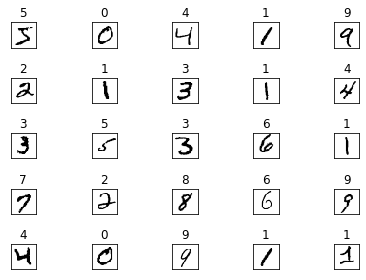

In [10]:
# 可视化：
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=5, ncols=5, sharex='all', sharey='all')
ax = ax.flatten()
for i in range(25):
    img = train_images[i].reshape(28, 28)
    ax[i].set_title(train_labels[i])
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

对数据集进行归一化等，作为输入数据：

In [11]:
train_images = train_images.reshape((60000, 28, 28, 1))
trainval_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

trainval_labels = to_categorical(train_labels)  # to_categorical 使用one_hot编码
test_labels = to_categorical(test_labels)

train_images = trainval_images[:50000]  # 训练集中拿出10000张作为验证集
train_labels = trainval_labels[:50000]

val_images = trainval_images[50000:]
val_labels = trainval_labels[50000:]
print(val_images.shape, val_labels.shape)

(10000, 28, 28, 1) (10000, 10)


接下来搭建CNN模型：

In [12]:
from keras import layers
from keras import models

# 卷积网络，用于特征提取
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 添加全连接层，用于分类
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 最后一层使用softmax作为激活函数
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

模型编译、训练：

In [14]:
from keras.callbacks import ModelCheckpoint
#编译
model.compile(optimizer='rmsprop',               # 优化器
              loss='categorical_crossentropy',   # 损失函数
              metrics=['accuracy'])              # 监控指标

# 训练 
history = model.fit(train_images, train_labels, epochs=5, batch_size=64)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
50000/50000 [==============================] - 28s 562us/step - loss: 0.1935 - acc: 0.9385
Epoch 2/5
50000/50000 [==============================] - 30s 600us/step - loss: 0.0530 - acc: 0.9833
Epoch 3/5
50000/50000 [==============================] - 24s 473us/step - loss: 0.0363 - acc: 0.9886
Epoch 4/5
50000/50000 [==============================] - 24s 474us/step - loss: 0.0270 - acc: 0.9915
Epoch 5/5
50000/50000 [==============================] - 25s 500us/step - loss: 0.0214 - acc: 0.9932


验证模型性能

In [15]:
val_loss, val_acc = model.evaluate(val_images, val_labels)
print(val_acc)   # 在验证集上的准确率
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

10000/10000 [==============================] - 3s 253us/step
0.9906
10000/10000 [==============================] - 2s 170us/step
0.9917


模型保存、加载与预测

In [38]:
from keras.models import load_model
import numpy as np
# 保存
model.save('./model_mnist.h5') 

# 加载
model = load_model('./model_mnist.h5')

# 预测
for i in range(10):
    im = test_images[i]
    im = np.expand_dims(im, axis=0)         # 因为模型的输入是（None， 28， 28， 1），所以必须保持shape一致
    im_label = np.argmax(test_labels[i])    # test_labels是one_hot编码后的数组，其中最大值的索引是其label
    pred_res = np.argmax(model.predict(im)) # 最大值的索引是其预测数字
    #print(pred_res, im_label)
    
    print('predict image res: %d, lable: %d, predcit %s!'%(pred_res, im_label, str(pred_res==im_label)))

predict image res: 7, lable: 7, predcit True!
predict image res: 2, lable: 2, predcit True!
predict image res: 1, lable: 1, predcit True!
predict image res: 0, lable: 0, predcit True!
predict image res: 4, lable: 4, predcit True!
predict image res: 1, lable: 1, predcit True!
predict image res: 4, lable: 4, predcit True!
predict image res: 9, lable: 9, predcit True!
predict image res: 5, lable: 5, predcit True!
predict image res: 9, lable: 9, predcit True!


predict image res: 9, lable: 4, predcit True!


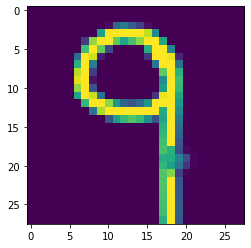

In [77]:
from PIL import Image
import numpy as np 
img = Image.open('1.png')
#print(test_images[0])
#img = plt.imread("4.png")
#plt.imshow(img)
lena = img.convert('L')
lena=np.array(lena)
#lena=lena.T
lena.reshape(-1,28,28,1)
lena = 1-lena.astype('float32') / 255
plt.imshow(lena)
#print(lena)
im0 = lena
#lena=[lena]
im0 = np.expand_dims(im0, axis=0)         # 因为模型的输入是（None， 28， 28， 1），所以必须保持shape一致
im0 = np.expand_dims(im0, axis=3) 
im_label0 = 4    # test_labels是one_hot编码后的数组，其中最大值的索引是其label
pred_res0 = np.argmax(model.predict(im0)) # 最大值的索引是其预测数字
#print(pred_res, im_label)
    
print('predict image res: %d, lable: %d, predcit %s!'%(pred_res0, im_label0, str(pred_res==im_label)))